#### To Start Off
- This project uses a dataset found on kaggle inorder to build an accurate based on 1400 recordings

In [ ]:
# Create new directory 
! mkdir dataset
# Download dataset from kaggle using my personal api which can be found on your kaggle account
! KAGGLE_USERNAME=ferasdahrooge1 KAGGLE_KEY=d65a33337f60ea5b0a5ee063dd09b34d kaggle datasets download -d uwrfkaggler/ravdess-emotional-speech-audio
# Unzip and save in newly created directory
! unzip ravdess-emotional-speech-audio.zip -d dataset

#### From the Dataset, Use the audio speech actors files to build a DataFrame

In [47]:
import os

dataset = "/Users/ferasdahrooge/Documents/voice-emotion-detector/dataset/audio_speech_actors_01-24"
actor_list = os.listdir(dataset)
path_list = []
gender_list = []
emotion_list = []

emotion_dictionary = {
  '01': 'neutral',
  '02': 'calm',
  '03': 'happy',
  '04': 'sad',
  '05': 'angry',
  '06': 'fearful',
  '07': 'disgust',
  '08': 'surprised'
}

for directory in actor_list:
    actor_files = os.listdir(os.path.join(dataset, directory))

    for audio_file in actor_files: 
        part = audio_file.split('.')[0]
        key = part.split('-')[2]
        if key in emotion_dictionary:
          gender_code = int(part.split('-')[6])
          path_list.append(f"{dataset}/{directory}/{audio_file}")
          gender_list.append('female' if gender_code % 2 == 0 else 'male')
          emotion_list.append(emotion_dictionary[key])

In [48]:
import pandas as pd

# Build DataFrame
dataframe = pd.concat([
  pd.DataFrame(path_list, columns=["path"]),
  pd.DataFrame(gender_list, columns=["gender"]),
  pd.DataFrame(emotion_list, columns=["emotion"])
] , axis=1)

In [49]:
dataframe

,path,gender,emotion
0,/Users/ferasdahrooge/Documents/voice-emotion-d...,female,angry
1,/Users/ferasdahrooge/Documents/voice-emotion-d...,female,fearful
2,/Users/ferasdahrooge/Documents/voice-emotion-d...,female,fearful
3,/Users/ferasdahrooge/Documents/voice-emotion-d...,female,angry
4,/Users/ferasdahrooge/Documents/voice-emotion-d...,female,disgust
...,...,...,...
1435,/Users/ferasdahrooge/Documents/voice-emotion-d...,female,happy
1436,/Users/ferasdahrooge/Documents/voice-emotion-d...,female,happy
1437,/Users/ferasdahrooge/Documents/voice-emotion-d...,female,calm
1438,/Users/ferasdahrooge/Documents/voice-emotion-d...,female,calm


In [50]:
# Check how many emotions and genders that exists in this dataFrame
df_count_gender = dataframe.groupby(["emotion", "gender"]).count().unstack()

In [51]:
df_count_gender

path     
gender    female male
emotion              
angry         96   96
calm          96   96
disgust       96   96
fearful       96   96
happy         96   96
neutral       48   48
sad           96   96
surprised     96   96

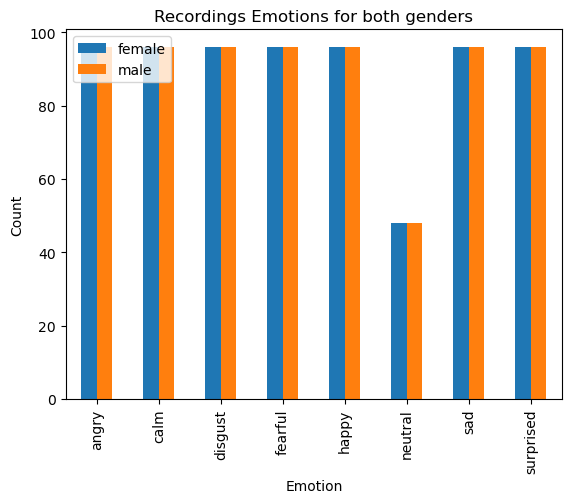

In [52]:
import matplotlib.pyplot as plt

df_count_gender.plot(kind = 'bar', stacked= False)
plt.xlabel('Emotion')
plt.ylabel('Count')
plt.title('Recordings Emotions for both genders')
plt.legend(["female","male"], loc = 'upper left')
plt.show()

#### After Plotting it's important to note these are more of recorded audios so they need to be transferred into a language that the model is capable of reading

In [87]:
import numpy as np
import soundfile as sf
from scipy.ndimage import label

In [88]:
def preprocess_audio(path):
  audio, sample_rate = sf.read(path)

    # Compute energy of the audio
  energy = np.sum(np.square(audio), axis=-1)

  # Determine the threshold for trimming
  threshold = np.max(energy) * 10**(-25/10) 

  # Detect non-silent regions
  non_silent_mask = energy > threshold
  labeled_mask, num_labels = label(non_silent_mask)

  # Find the longest non-silent region
  longest_region = np.argmax(np.bincount(labeled_mask.ravel())[1:]) + 1
  non_silent_indices = np.where(labeled_mask == longest_region)[0]

  # Extract the trimmed audio
  trimmed_audio = audio[non_silent_indices]

  # Pad or truncate audio to desired length
  target_length = 180000
  if len(trimmed_audio) < target_length:
      pad_amount = target_length - len(trimmed_audio)
      padded_audio = np.pad(trimmed_audio, (0, pad_amount), 'constant')
  else:
      padded_audio = trimmed_audio[:target_length]

  return padded_audio, sample_rate
  

In [89]:
emotion_dictionary_label = {
  "neutral": 0,
  "calm" : 1,
  "happy" : 2,
  "sad" : 3,
  "angry" : 4,
  "fearful" : 5,
  "disgust" : 6,
  "surprised" : 7
}
def encode(label):
  return emotion_dictionary_label.get(label)

In [ ]:
zcr_list = []
rms_list = []
mfccs_list = []
emotion_list = []
FRAME_LENGTH = 2048
HOP_LENGTH = 512
for row in dataframe.itertuples():
    try:
        y, sr = preprocess_audio(row.path)
        print(y, sr)
        
        # Compute zero-crossing rate
        frame_length = FRAME_LENGTH
        hop_length = HOP_LENGTH
        zcr = np.sum(np.abs(np.diff(np.sign(y))), axis=-1) / (2 * frame_length)
        
        # Compute root mean square
        rms = np.sqrt(np.mean(np.square(y), axis=-1))
        
        # Compute MFCCs
        n_mfcc = 13
        mfccs = np.zeros((n_mfcc, y.shape[0] // hop_length))
        for i, hop in enumerate(range(0, y.shape[0] - frame_length + 1, hop_length)):
            frame = y[hop : hop + frame_length]
            mfccs[:, i] = your_mfcc_computation_function(frame, sr, n_mfcc)
        
        zcr_list.append(zcr)
        rms_list.append(rms)
        mfccs_list.append(mfccs)
        emotion_list.append(encode(row.emotion))
    except:
        print(f"Failed for path: {row.path}")
